In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%load_ext autoreload
%autoreload 1

Author: Andrew Tarzia

Date Created: 12 Jul 2018

Distributed under the terms of the MIT License.

In [2]:
import numpy as np
import pandas as pd
import os
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors3D import NPR1, NPR2, PMI1, PMI2, PMI3
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Geometry import rdGeometry
from rdkit.Chem import PyMol
import py3Dmol
from ipywidgets import interact, interactive, fixed
from rdkit import Geometry
import tempfile
import matplotlib.pyplot as plt
%aimport ercollect.rdkit_functions
%aimport ercollect.ellipsoid

## This section looks at analysing the ellipsoids fit to a VDW cloud as a function of parameters

In [301]:
name, smiles = 'n-octane', 'CCCCCCCC'
output_dir = '/home/atarzia/psp/molecule_param/'
m = Chem.MolFromSmiles(smiles)
m = Chem.AddHs(m)

In [307]:
# get conformers using ETKDG algorithm
cids = Chem.EmbedMultipleConfs(mol=m, numConfs=5,
                               useExpTorsionAnglePrefs=True,
                               useBasicKnowledge=True,
                               randomSeed=1000)

In [308]:
# quick UFF optimize
for cid in cids:
    Chem.UFFOptimizeMolecule(m, confId=cid)

### Inside get_ellip_diameters()

In [310]:
# only interested in first (and only) conformer
confId = 2

In [311]:
conf = m.GetConformer(confId)

In [312]:
print(min(conf.GetPositions()[:, 0]), max(conf.GetPositions()[:, 0]))
print(min(conf.GetPositions()[:, 1]), max(conf.GetPositions()[:, 1]))
print(min(conf.GetPositions()[:, 2]), max(conf.GetPositions()[:, 2]))

-4.7236520657266095 4.991454008315334
-1.4649908998099799 1.6813811193422012
-1.4189326821343222 1.3992416591048715


### Inside get_molec_shape()

In [313]:
box = Chem.ComputeConfBox(conf)

In [314]:
print([(i.x, i.y, i.z) for i in box])

[(-6.7236520657266095, -3.4649908998099797, -3.418932682134322), (6.991454008315334, 3.681381119342201, 3.3992416591048715)]


In [329]:
boxMargin = 4

In [330]:
sideLen = (box[1].x-box[0].x + 2*boxMargin,
           box[1].y-box[0].y + 2*boxMargin,
           box[1].z-box[0].z + 2*boxMargin)

In [331]:
print(sideLen)

(21.715106074041945, 15.146372019152182, 14.818174341239194)


In [332]:
spacing = 0.4

In [333]:
shape = rdGeometry.UniformGrid3D(2*sideLen[0],
                                     2*sideLen[1],
                                     2*sideLen[2],
                                     spacing=spacing)

In [334]:
vdwScale = 0.8

In [335]:
Chem.EncodeShape(m, shape, confId=confId, ignoreHs=False,
                     vdwScale=vdwScale)

### Returned

In [336]:
# get ellipsoid fitting all points with value > 2
# - i.e. within vdw shape
hit_points = []
all_points = []
for idx in range(shape.GetSize()):
    pt = shape.GetGridPointLoc(idx)
    value = shape.GetVal(idx)
    point = np.array([pt.x, pt.y, pt.z])
    all_points.append(point)
    if value > 1:
        hit_points.append(point)
all_points = np.asarray(all_points)   
hit_points = np.asarray(hit_points)

In [337]:
print(len(all_points))

613016


In [338]:
print(len(hit_points))

2432


In [339]:
print(min(all_points[:, 0]), max(all_points[:, 0]))
print(min(all_points[:, 1]), max(all_points[:, 1]))
print(min(all_points[:, 2]), max(all_points[:, 2]))

-21.715106074041945 21.48489392595806
-15.146372019152182 14.853627980847818
-14.818174341239194 14.381825658760809


In [328]:
print(min(all_points[:, 0]), max(all_points[:, 0]))
print(min(all_points[:, 1]), max(all_points[:, 1]))
print(min(all_points[:, 2]), max(all_points[:, 2]))

-29.715106074041945 29.48489392595806
-23.14637201915218 22.85362798084782
-22.818174341239192 22.38182565876081


In [287]:
a = hit_points

(array([156., 177., 271., 254., 284., 249., 287., 310., 305., 124.]),
 array([-6.02991146, -4.82991146, -3.62991146, -2.42991146, -1.22991146,
        -0.02991146,  1.17008854,  2.37008854,  3.57008854,  4.77008854,
         5.97008854]),
 <a list of 10 Patch objects>)

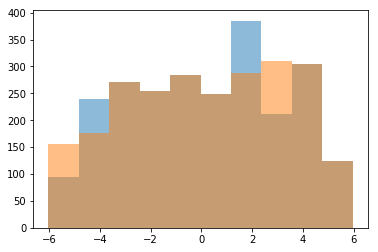

In [298]:
plt.hist(hit_points[:, 0], alpha=0.5)
plt.hist(a[:, 0], alpha=0.5)

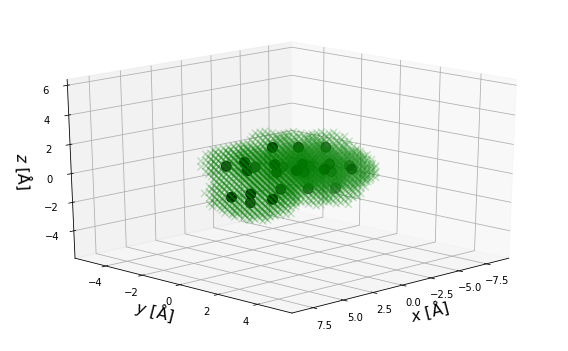

In [196]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# plot points
atom_positions = conf.GetPositions()
ax.scatter(atom_positions[:, 0], atom_positions[:, 1],
           atom_positions[:, 2],
           color='k', marker='o', s=100)
ax.scatter(hit_points[:, 0], hit_points[:, 1], hit_points[:, 2],
           color='g', marker='x', edgecolor=None,
           s=50, alpha=0.2)

# plot ellipsoid
# ET.plotEllipsoid(center, radii, rotation, ax=ax, plotAxes=False)
ax.set_xlabel("$x$ [$\mathrm{\AA}$]", fontsize=16)
ax.set_ylabel("$y$ [$\mathrm{\AA}$]", fontsize=16)
ax.set_zlabel("$z$ [$\mathrm{\AA}$]", fontsize=16)
# ax.set_xlim(box[0].x-boxMargin, box[1].x+boxMargin)
# ax.set_ylim(box[0].y-boxMargin, box[1].y+boxMargin)
# ax.set_zlim(box[0].z-boxMargin, box[1].z+boxMargin)
ax.set_xlim(box[0].x-2, box[1].x+2)
ax.set_ylim(box[0].y-2, box[1].y+2)
ax.set_zlim(box[0].z-2, box[1].z+2)
ax.set_aspect('equal', 'box')
# plt.axis('off')

dist = [20, 30]
angles = [45, -180]
ax.view_init(dist[0], angles[0])
fig.tight_layout()
fig.savefig(output_dir+'temporary_1.pdf', dpi=720,
            bbox_inches='tight')

In [142]:
# save too dicts
if input('you sure?') == 't':
    hp = {'4_pt4': [],
          '8_pt4': [],
          '4_pt6': [],
          '8_pt6': []}

you sure? 


In [143]:
# hp['4_pt4'] = a
# hp['8_pt4'] = a
hp['4_pt6'] = a
# hp['8_pt6'] = a

In [144]:
hp

{'4_pt4': array([[-1.36725273,  1.14447124, -3.1843216 ],
        [-2.96725273, -0.85552876, -2.7843216 ],
        [-0.96725273, -0.85552876, -2.7843216 ],
        ...,
        [ 0.63274727,  1.14447124,  2.4156784 ],
        [ 1.03274727,  1.14447124,  2.4156784 ],
        [ 1.43274727,  1.14447124,  2.4156784 ]]),
 '4_pt6': array([[-0.76725273, -0.65552876, -2.9843216 ],
        [-1.36725273, -0.05552876, -2.9843216 ],
        [-0.76725273, -0.05552876, -2.9843216 ],
        ...,
        [ 0.43274727,  1.14447124,  2.4156784 ],
        [ 1.03274727,  1.14447124,  2.4156784 ],
        [ 1.63274727,  1.14447124,  2.4156784 ]]),
 '8_pt4': array([[-1.36725273,  1.14447124, -3.1843216 ],
        [-2.96725273, -0.85552876, -2.7843216 ],
        [-0.96725273, -0.85552876, -2.7843216 ],
        ...,
        [ 0.63274727,  1.14447124,  2.4156784 ],
        [ 1.03274727,  1.14447124,  2.4156784 ],
        [ 1.43274727,  1.14447124,  2.4156784 ]]),
 '8_pt6': array([[-3.36725273, -0.85552876, -2

In [146]:
for i, j in hp.items():
    print(i)
    print(len(j))
    

4_pt4
2432
8_pt4
2432
4_pt6
722
8_pt6
714


## Get timing information for calculating molecular size

In [8]:
import time

In [21]:
name, smiles = 'n-octane', 'CCCCCCCC'
output_dir = '/home/atarzia/psp/molecule_DBs/atarzia/'
# spacing, conf
param_test = [(0.6, 10), (0.6, 50), (0.6, 200), (0.4, 10), (0.4, 50), (0.4, 200), (0.8, 10), (0.8, 50), (0.8, 200), (0.5, 10), (0.5, 50), (0.5, 200),]
result = []
for p in param_test:
    print('doing:', p)
    os.system('rm '+output_dir+name+'_diam_result.csv')
    start_time = time.time()
    res = ercollect.rdkit_functions.calc_molecule_diameter(name, smiles, out_dir=output_dir,
                                             MW_thresh=2000, 
                                             vdwScale=0.8, 
                                             boxMargin=4.0,
                                             spacing=p[0], 
                                             show_vdw=False, plot_ellip=False,
                                             N_conformers=p[1])
    end_time = time.time()
    t = end_time - start_time
    result.append(t)

doing: (0.6, 10)
doing: (0.6, 50)
doing: (0.6, 200)
doing: (0.4, 10)
doing: (0.4, 50)
doing: (0.4, 200)
doing: (0.8, 10)
doing: (0.8, 50)
doing: (0.8, 200)
doing: (0.5, 10)
doing: (0.5, 50)
doing: (0.5, 200)


In [22]:
result

[2.6102492809295654,
 12.930054187774658,
 51.61365842819214,
 12.452444314956665,
 85.55890369415283,
 238.37334775924683,
 1.1112666130065918,
 5.299277067184448,
 20.148927688598633,
 4.761769771575928,
 25.313056468963623,
 99.35008955001831]

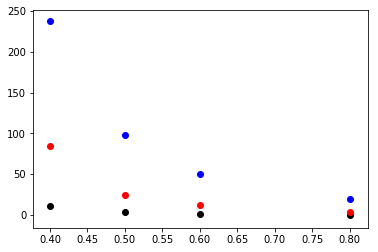

In [24]:
for p, r in zip(param_test, result):
    if p[1] == 10:
        plt.scatter(p[0], r-min(result), c='k')
    if p[1] == 50:
        plt.scatter(p[0], r-min(result), c='r')
    if p[1] == 200:
        plt.scatter(p[0], r-min(result), c='b')

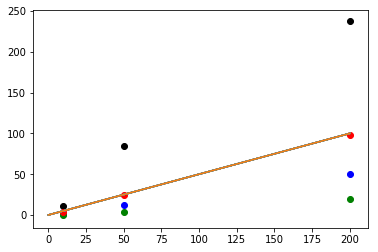

In [28]:
for p, r in zip(param_test, result):
    if p[0] == 0.4:
        plt.scatter(p[1], r-min(result), c='k')
    if p[0] == 0.5:
        plt.scatter(p[1], r-min(result), c='r')
    if p[0] == 0.6:
        plt.scatter(p[1], r-min(result), c='b')
    if p[0] == 0.8:
        plt.scatter(p[1], r-min(result), c='green')
    plt.plot(np.linspace(0, 200, 2), np.linspace(0, 100, 2))

## How does the minimum intermediate diameter change as a function of N conformers and random seed?

In [11]:
name, smiles = 'n-octane', 'CCCCCCCC'
output_dir = '/home/atarzia/psp/molecule_DBs/atarzia/'
# random seed, conf
param_test = [(1, 10), (1, 50), (1, 200), (1, 1000), (10, 10), (10, 50), (10, 200), (10, 1000), 
              (1000, 10), (1000, 50), (1000, 200), (1000, 1000), (135113, 10), (135113, 50), (135113, 200), (135113, 1000),
              (7973855, 10), (7973855, 50), (7973855, 200), (7973855, 1000),]
result = []
for p in param_test:
    print('doing:', p)
    os.system('rm '+output_dir+name+'_diam_result.csv')
    res = ercollect.rdkit_functions.calc_molecule_diameter(name, smiles, out_dir=output_dir,
                                             MW_thresh=2000, 
                                             vdwScale=0.8, 
                                             boxMargin=4.0,
                                             spacing=0.5, 
                                             show_vdw=False, plot_ellip=False,
                                             N_conformers=p[1],
                                             rSeed=p[0])
    result.append(min(res.diam2))

doing: (1, 10)
doing: (1, 50)
doing: (1, 200)
doing: (1, 1000)
doing: (10, 10)
doing: (10, 50)
doing: (10, 200)
doing: (10, 1000)
doing: (1000, 10)
doing: (1000, 50)
doing: (1000, 200)
doing: (1000, 1000)
doing: (135113, 10)
doing: (135113, 50)
doing: (135113, 200)
doing: (135113, 1000)
doing: (7973855, 10)
doing: (7973855, 50)
doing: (7973855, 200)
doing: (7973855, 1000)


In [12]:
result

[5.8043224920316945,
 5.103240290832818,
 5.103240290832818,
 5.103240290832818,
 5.6774695208655865,
 5.337594474073877,
 5.234933595860988,
 5.0903211247663505,
 5.282262866984238,
 5.249760926771138,
 5.132127195697385,
 5.103748205886893,
 5.2101676992667825,
 5.2101676992667825,
 5.175478905664319,
 5.063515205807234,
 5.780915663861822,
 5.145997525071174,
 5.145997525071174,
 5.124655767040809]

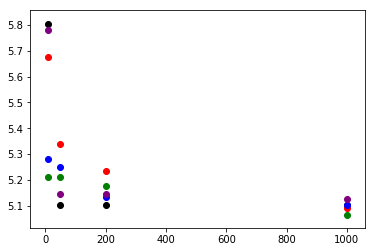

In [13]:
for p, r in zip(param_test, result):
    if p[0] == 1:
        plt.scatter(p[1], r, c='k')
    if p[0] == 10:
        plt.scatter(p[1], r, c='r')
    if p[0] == 1000:
        plt.scatter(p[1], r, c='b')
    if p[0] == 135113:
        plt.scatter(p[1], r, c='green')
    if p[0] == 7973855:
        plt.scatter(p[1], r, c='purple')

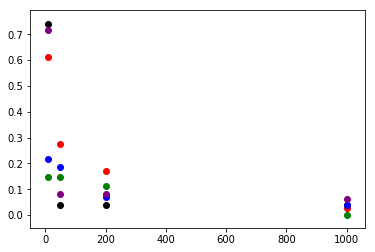

In [14]:
for p, r in zip(param_test, result):
    if p[0] == 1:
        plt.scatter(p[1], r-min(result), c='k')
    if p[0] == 10:
        plt.scatter(p[1], r-min(result), c='r')
    if p[0] == 1000:
        plt.scatter(p[1], r-min(result), c='b')
    if p[0] == 135113:
        plt.scatter(p[1], r-min(result), c='green')
    if p[0] == 7973855:
        plt.scatter(p[1], r-min(result), c='purple')